# Intuitive AI: Session 2

## Study Club Overview
* Today: Get into the details of NN, Flax, and model thinking
* Next Session: NN Architecture overview. CNN, RNN, Transformers
* Implementing (but more like copying) a Basic GPT
* TBD (and new!): LLM Ecosystem
* TBD: Shaping LLMs to do what we want
* Maybe more stuff later

## Study Club Overview Annotated
* Today: Get into the details of NN, Flax, and model thinking
  * What are these things really at their core?
* Next Session: NN Architecture overview. CNN, RNN, Transformers
  * How can we piece them together?
* Basic Languge Models and implementing (but more like copying) a Basic GPT
  * What does a modern architecture look like for something we can train ourselves
* TBD: LLM Ecosystem
  * A bunch of hot takes from Ravin on the landscape of closed source vs open source vs sorta open LLMs
* Shaping LLMs to do what we want
  * Making these things work for us

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Today
Understanding every part of a basic NN

  * The basic math (it's way easier than you may think)
  * The code (the more important one so we don't get overwhelemd later)
  * The mathematical ideas (I don't think this gets covered enough)

## Here's our our plan
1. Create some synthetic X and Y data generated from a linear model
  * Foundational scipy and numpy usage
2. Use Neural Nets to recover the parameters to show how they work
  * Build this in flax
3. Do the same with a non linear data generating function
  * Show that NNs can fit "anything"

## What to remember
* General intuition of how NN works
* Flax model definition syntax
* How parameters are estimated
  * Loss Function
  * Usage of optax

## References
* NN are just lin reg: https://joshuagoings.com/2020/05/05/neural-network/
* Why we want multi layer NN https://lightning.ai/pages/courses/deep-learning-fundamentals/training-multilayer-neural-networks-overview/4-5-multilayer-neural-networks-for-regression-parts-1-2/
* Flax Docs https://flax.readthedocs.io/en/latest/

## Generating some data
So we have something to do

## Our data generating function

$$ y = mx + b $$

$$ y = m_0 * x_0 + m_1 * x_1 + b $$

## Set Coefficients and constants
This is what we're going to recover

In [2]:
m_0, m_1 = 1.1, 2.1
intercept = bias = 3.1

In [3]:
# The shape needs to be (1,2). You'll see why below
coefficients = np.array([[m_0, m_1]])

## Generate some observed x data
We need two dimensions because we have two coefficients

In [4]:
x_0, x_1 = 0, 1
coefficients[0][0] * x_0 + coefficients[0][1] * x_1 + bias

5.2

In [5]:
x_0, x_1 = 1, 0
coefficients[0][0] * x_0 + coefficients[0][1] * x_1 + bias

4.2

## Plot our function grid

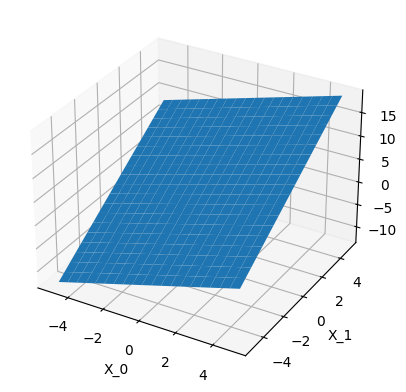

In [6]:
from mpl_toolkits.mplot3d import Axes3D
# Define grid range
x_0_range = np.linspace(-5, 5, 20)
x_1_range = np.linspace(-5, 5, 20)
X_0, x_1 = np.meshgrid(x_0_range, x_1_range)

# Calculate corresponding z coordinates

Y = coefficients[0][0] * X_0 + coefficients[0][1] * x_1 + bias

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot plane
ax.plot_surface(X_0, x_1, Y)

# Set axis labels
ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

ax.mouse_init()

## Generate Random X_0, X_1 points
This is what we'd get in real life. Not everything is on a grid

In [7]:
rng = np.random.default_rng(12345)
x_obs = rng.uniform(-10, 10, size=(200,2))
x_obs[:10]

array([[-5.45327955, -3.66483321],
       [ 5.94730915,  3.52509342],
       [-2.17780899, -3.34372144],
       [ 1.96617507, -6.26531629],
       [ 3.45512088,  8.83605731],
       [-5.03508571,  8.97762304],
       [ 3.34474906, -8.08204129],
       [-1.16320668,  7.72959839],
       [ 3.94907   , -3.47054272],
       [ 4.67856327, -5.59730089]])

## Side Track: Do some matrix multplication

In [8]:
y_obs = coefficients[0][0] * x_obs[0][0] + coefficients[0][1] * x_obs[0][1] + bias
y_obs

-10.594757237912647

## Practical Tip 1: You're going to check shapes, so, much
With neural nets these matter a lot

In [9]:
coefficients.shape, x_obs.shape

((1, 2), (200, 2))

## Matrix Multiplication
(1,2) @ (2, 200) = (1,200) 

In [10]:
# Typically done this way in NN literature so we get a column vector 
y_obs = (x_obs @ coefficients.T) + bias
y_obs[:5]

array([[-10.59475724],
       [ 17.04473623],
       [ -6.31740492],
       [ -7.89437163],
       [ 25.45635331]])

## Einsum is really nice

In [11]:
y_obs = np.einsum('ij,kj->ki', coefficients, x_obs) + bias
y_obs[:5]

array([[-10.59475724],
       [ 17.04473623],
       [ -6.31740492],
       [ -7.89437163],
       [ 25.45635331]])

## Lets make add some noise to Y 
In real life we'll never perfectly get our exact measurements. We should add to add some noise

In [12]:
noise_sd = .5
y_obs_noisy = y_obs + stats.norm(0, noise_sd).rvs(y_obs.shape)

## What we did until here
* We decided our data generated function is a two coefficient regression with a bias
  * $$ y = m_0 * x_0 + m_1 * x_1 + b $$
* Picked some arbitrary parameters
  * `m_0, m_1 = 1.1, 2.1`
  * `intercept = bias = 3.1`
* We picked some random x_0 and x_1 observations and calculated our y1_observations
  * In the real world we'd have observed this
  * weight = m1*height + m2+width
* We generated some random x_0 and x_1 points
  * Used that to calculate Y
* Added some random noise to Y
  * The real world is messy
**No modeling has been completed yet**

## Reminder of our Goal
The goal here is to figure out the **coefficients m_0, m_1, bias** using our **observed x_0, x_! data**

## How can we we do this?
Lots of ways
1. "Linear Regression"
2. "Machine Learning 
3. Bayesian Regression
4. Neural Nets

## Bayesian Model

In [13]:
import bambi as bmb
import arviz as az

In [14]:
df = pd.DataFrame({"y":y_obs_noisy[:, 0], "x0":x_obs[:,0], "x1":x_obs[:,1]})
model = bmb.Model('y ~ x0 + x1', data=df)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x0, x1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [15]:
model = bmb.Model('y ~ x0 + x1', data=df)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x0, x1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


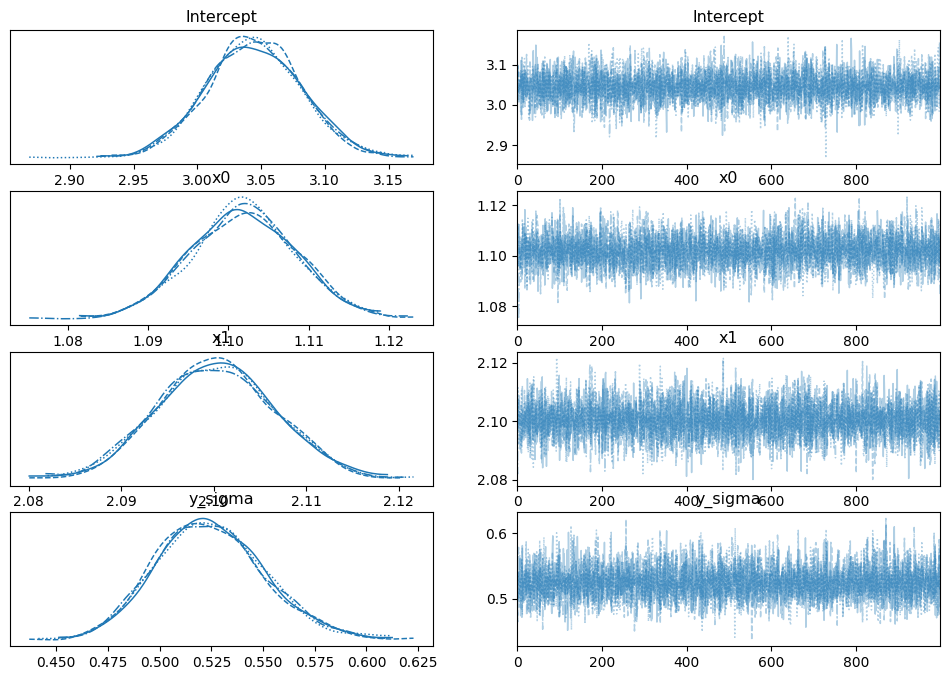

In [16]:
az.plot_trace(idata);

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.044,0.037,2.976,3.115,0.0,0.0,6762.0,3188.0,1.0
x0,1.102,0.006,1.090,1.115,0.0,0.0,5583.0,3508.0,1.0
x1,2.100,0.006,2.089,2.112,0.0,0.0,7502.0,3360.0,1.0
y_sigma,0.525,0.026,0.477,0.575,0.0,0.0,6366.0,3287.0,1.0


## Exercise for you to try
Fit this this linear regression using
1. A traditional solver like statmodels
2. Any ML method from scikit learn

## The point I'm trying to make
These single terms often conflate three things
1. The type of data
2. The model architecture
3. The parameter estimation method
4. The libraries used
5. The purpose of the analysis

When learning its important to understand the distinction of these parts. In this study club we'll be weaving through these topics

## Neural Nets are just lin reg at their core as well



<center>
  <img src="img/LinearReg.png" style="height:400"; />
</center>

## Neural Nets (in Flax)

In [18]:
import flax.linen as nn

In [19]:
class LinearRegression(nn.Module):
    # Define the neural network architecture
    def setup(self):
        """Single output, I dont need to specify shape"""
        self.dense = nn.Dense(features=1)

    # Define the forward pass
    def __call__(self, x):
        y_pred = self.dense(x)
        return y_pred

In [20]:
model = LinearRegression()

In [21]:
key = jax.random.PRNGKey(0)

## Initialize Random Parameters

In [22]:
params = model.init(key, x_obs)
params

FrozenDict({
    params: {
        dense: {
            kernel: Array([[ 0.23232014],
                   [-1.5953745 ]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
})

## Print Model Architecture

In [23]:
print(model.tabulate(key, x_obs,
      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

                              LinearRegression Summary                               
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path  ┃ module           ┃ inputs         ┃ outputs        ┃ params               ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│       │ LinearRegression │ float32[200,2] │ float32[200,1] │                      │
├───────┼──────────────────┼────────────────┼────────────────┼──────────────────────┤
│ dense │ Dense            │ float32[200,2] │ float32[200,1] │ bias: float32[1]     │
│       │                  │                │                │ kernel: float32[2,1] │
│       │                  │                │                │                      │
│       │                  │                │                │ 3 (12 B)             │
├───────┼──────────────────┼────────────────┼────────────────┼──────────────────────┤
│       │                  │                │          Total │ 3 (12 B)             │
└───────┴──────────────────┴────────────────┴────────────────┴──────────────────────┘
                                                                                     
                             Total Parameters: 3 (12 B)                              

## Estimate y from our random parameters
These numbesr are meaingless. I just want to show you that you can 
* Take any parameter dictionary
* Any X value
* Forward it through the model

In [24]:
x1, x2 = 1, 0
model.apply(params, [1,0])

Array([0.23232014], dtype=float32)

## Estimating our parameters using gradient descent
Basically
1. Start with some parameters that are bad
2. Figure out the direction that is less bad
3. Move that direction


### You need a loss function (to define a loss surface)

We're going to use L2 loss, also know as mean squared error

https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

## L2 Loss by Hand
1. Calculating the y estimate
2. Calculating hte lass

In [25]:
m = params["params"]["dense"]["kernel"]
m

Array([[ 0.23232014],
       [-1.5953745 ]], dtype=float32)

In [26]:
bias = params["params"]["dense"]["bias"]

In [27]:
m = params["params"]["dense"]["kernel"]
y_0_pred = m[0] * x_obs[0][0] + m[1] * x_obs[0][1] + bias
y_0_pred

Array([4.5798745], dtype=float32)

In [28]:
(y_0_pred - y_obs[0])**2 / 2

Array([115.13471], dtype=float32)

## Use Optax instead

In [29]:
import optax

In [30]:
y_pred = model.apply(params, x_obs[0])
y_pred

Array([4.5798745], dtype=float32)

In [31]:
y_pred = model.apply(params, x_obs[0])

optax.l2_loss(y_pred[0], y_obs[0][0])

Array(115.13471, dtype=float32)

### Training
Which basically means doing that calculation a bunch of times 

In [32]:
from flax.training import train_state  # Useful dataclass to keep train state

In [33]:
# Note so jax needs to differentiate this 
@jax.jit
def flax_l2_loss(params, x, y_true): 
    y_pred = model.apply(params, x)
    total_loss = optax.l2_loss(y_pred, y_true).sum()
    
    return total_loss

flax_l2_loss(params, x_obs[0], y_obs[0])

Array(115.13471, dtype=float32)

## How far do we step each time?


In [34]:
optimizer = optax.adam(learning_rate=0.001)

## Storing training state

In [35]:
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)
type(state)

flax.training.train_state.TrainState

In [36]:
state

TrainState(step=0, apply_fn=LinearRegression(), params=FrozenDict({
    params: {
        dense: {
            kernel: Array([[ 0.23232014],
                   [-1.5953745 ]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
}), tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x14803b6a0>, update=<function chain.<locals>.update_fn at 0x148039e40>), opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=FrozenDict({
    params: {
        dense: {
            bias: Array([0.], dtype=float32),
            kernel: Array([[0.],
                   [0.]], dtype=float32),
        },
    },
}), nu=FrozenDict({
    params: {
        dense: {
            bias: Array([0.], dtype=float32),
            kernel: Array([[0.],
                   [0.]], dtype=float32),
        },
    },
})), EmptyState()))

## Actual training

In [37]:
epochs = 10000
_loss = []

for epoch in range(epochs):
    # Calculate the gradient
    loss, grads = jax.value_and_grad(flax_l2_loss)(state.params, x_obs, y_obs_noisy)
    _loss.append(loss)
    # Update the model parameters
    state = state.apply_gradients(grads=grads)

## Training Loss

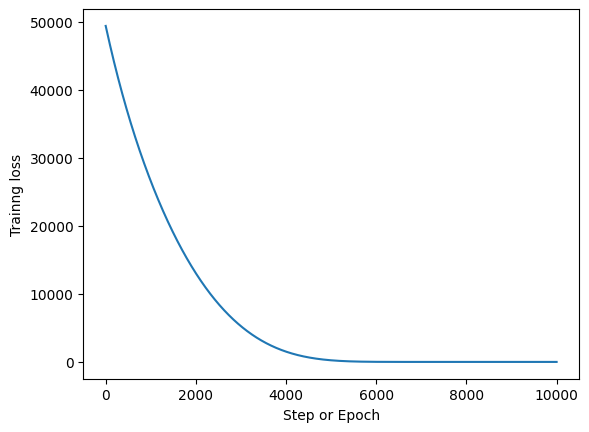

In [38]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), _loss)
ax.set_xlabel("Step or Epoch")
ax.set_ylabel("Trainng loss");

## Final Parmameters

In [39]:
state.params

FrozenDict({
    params: {
        dense: {
            bias: Array([3.0445216], dtype=float32),
            kernel: Array([[1.1018059],
                   [2.100352 ]], dtype=float32),
        },
    },
})

## What if data is non linear?
Show model can't fit
but then we change architecture and it does

In [40]:
x_non_linear = np.linspace(-10, 10, 100)
m = 2
y_non_linear = m*x_non_linear**2

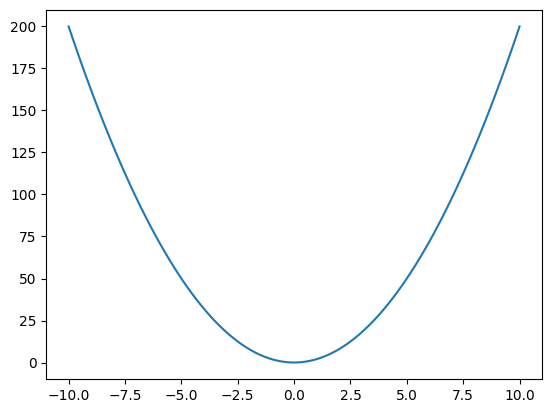

In [41]:
fig, ax = plt.subplots()
ax.plot(x_non_linear,y_non_linear);

## Initialize Params for our  model
Shape Problems

In [42]:
params = model.init(key, x_non_linear)
params["params"]["dense"]["kernel"].shape

(100, 1)

## We need to reshape X

In [43]:
x_non_linear[..., None][:5]

array([[-10.        ],
       [ -9.7979798 ],
       [ -9.5959596 ],
       [ -9.39393939],
       [ -9.19191919]])

In [44]:
params = model.init(key, x_non_linear[..., None])
params

FrozenDict({
    params: {
        dense: {
            kernel: Array([[-0.92962414]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
})

In [45]:
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)
type(state)

flax.training.train_state.TrainState

In [46]:
epochs = 10000
_loss = []

for epoch in range(epochs):
    # Calculate the gradient, shapes are really annoying
    loss, grads = jax.value_and_grad(flax_l2_loss)(state.params, x_non_linear[..., None], y_non_linear[..., None])
    _loss.append(loss)
    # Update the model parameters
    state = state.apply_gradients(grads=grads)

In [47]:
state.params

FrozenDict({
    params: {
        dense: {
            bias: Array([9.870098], dtype=float32),
            kernel: Array([[-7.460363e-08]], dtype=float32),
        },
    },
})

In [48]:
y_pred = model.apply(state.params, x_non_linear[..., None])

In [49]:
y_pred[:5]

Array([[9.870099],
       [9.870099],
       [9.870099],
       [9.870099],
       [9.870099]], dtype=float32)

## This is a terrible fit

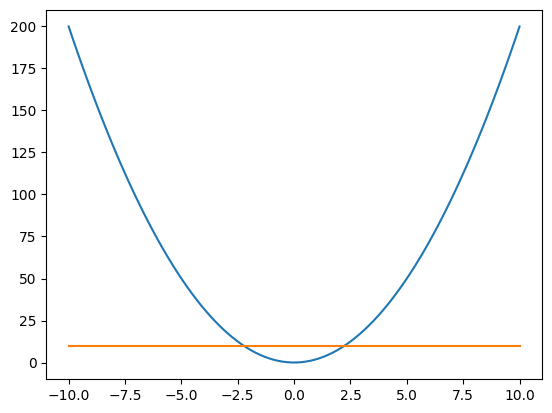

In [50]:
fig, ax = plt.subplots()
ax.plot(x_non_linear, y_non_linear, label="Actual");
ax.plot(x_non_linear, y_pred, label="Predicted");

## Nonlinear Regression

In [51]:
class NonLinearRegression(nn.Module):
    # Define the neural network architecture
    def setup(self):
        """Single output, I dont need to specify shape"""
        self.hidden_layer_1 = nn.Dense(features=10)
        self.hidden_layer_2 = nn.Dense(features=10)
        self.dense_out = nn.Dense(features=1)

    # Define the forward pass
    def __call__(self, x):
        hidden_x_1 = self.hidden_layer_1(x)
        hidden_x_2 = self.hidden_layer_2(hidden_x_1)
        y_pred = self.dense_out(hidden_x_2)
        return y_pred

In [52]:
class NonLinearRegression(nn.Module):
    
    # Define the neural network architecture
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)                 # create inline Flax Module submodules
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)       # shape inference
        return x

In [53]:
model = NonLinearRegression()
params = model.init(key, x_non_linear[..., None])
params

FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-4.7543818e-01,  8.1012428e-01, -3.9807501e-01,  1.3978344e-01,
                    -8.3962709e-01,  8.2309045e-02, -2.1468928e-01,  2.3707788e-01,
                    -2.8361431e-01,  7.6163888e-02,  5.8772308e-01, -3.7088424e-01,
                    -6.7414981e-01,  9.1145325e-01,  1.0080450e+00,  2.5671810e-01,
                     9.9041790e-01, -1.2188204e-01, -2.2279836e-01,  2.2143915e+00,
                     8.6724967e-01,  2.6094243e-02, -1.1773374e+00, -8.7350380e-01,
                    -1.7519502e-01,  1.0215735e+00,  1.9345186e+00, -1.0982813e+00,
                     8.8535964e-02,  8.7364709e-01,  5.3921205e-01,  1.2032949e-01,
                     8.0694962e-01,  1.3990604e+00, -6.8736351e-01,  4.1746104e-01,
                     1.3341872e-01,  1.3761107e-03, -3.8987619e-01, -7.2356844e-01,
                    -3.8679430e-01, -9.5925498e-01,  1.2654461e+00,  1.7892410e-01,
                    -5

In [54]:
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

In [75]:
epochs = 10000
_loss = []

for epoch in range(epochs):
    # Calculate the gradient. Also shapes are really annoying
    loss, grads = jax.value_and_grad(flax_l2_loss)(state.params, x_non_linear[..., None], y_non_linear[..., None])
    _loss.append(loss)
    # Update the model parameters
    state = state.apply_gradients(grads=grads)

In [56]:
state;

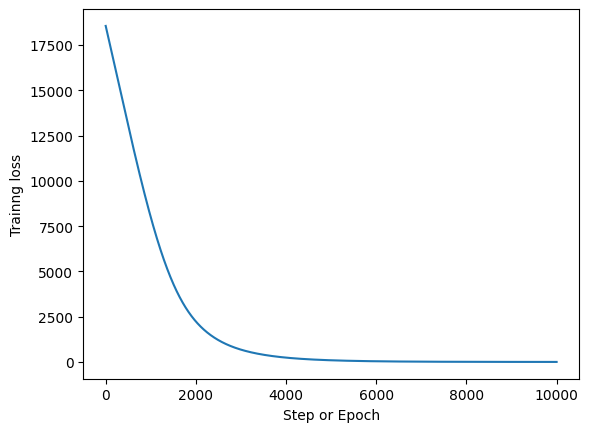

In [77]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), _loss)
ax.set_xlabel("Step or Epoch")
ax.set_ylabel("Trainng loss");

## Calculate Predictions

In [80]:
y_pred_non_linear = model.apply(state.params, x_non_linear[..., None])

## Plot Predictions

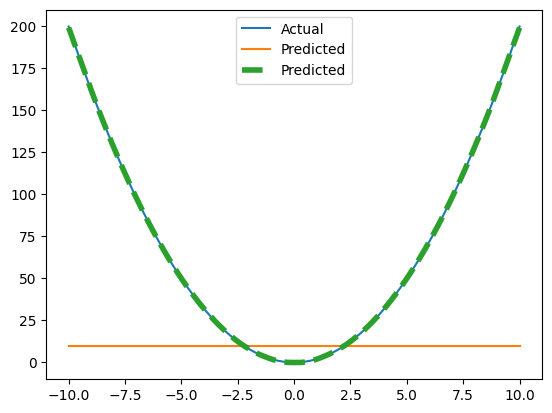

In [82]:
fig, ax = plt.subplots()
ax.plot(x_non_linear, y_non_linear, label="Actual");
ax.plot(x_non_linear, y_pred, label="Predicted");
ax.plot(x_non_linear, y_pred_non_linear, label="Predicted", ls='--', lw=4)
plt.legend();